Extracting Goertzel features...
Feature matrix shape: (757, 67)

Training Extra Trees (ALL features)...

Extra Trees accuracy (ALL): 0.9342105263157895
              precision    recall  f1-score   support

      normal       0.94      0.91      0.93        68
   udrykning       0.93      0.95      0.94        84

    accuracy                           0.93       152
   macro avg       0.93      0.93      0.93       152
weighted avg       0.93      0.93      0.93       152



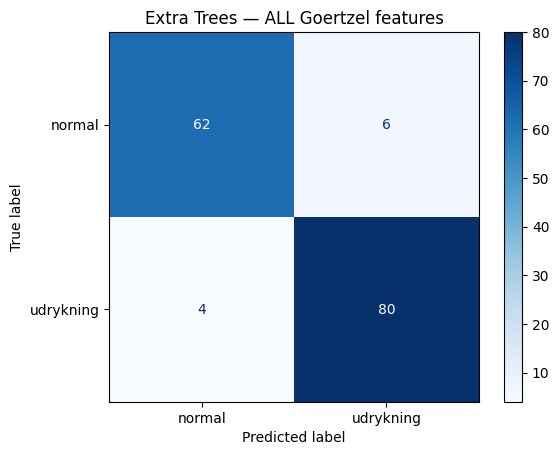


TOP 10 EXTRA TREES FEATURES:
 1. corr_xy
 2. y_rms
 3. y_max
 4. y_band15_40
 5. corr_xz
 6. y_kurt
 7. y_band5_15
 8. y_band0_5
 9. y_mean
10. y_energy

Training Extra Trees (TOP 10 features)...

Extra Trees accuracy (TOP 10): 0.8355263157894737
              precision    recall  f1-score   support

      normal       0.81      0.82      0.82        68
   udrykning       0.86      0.85      0.85        84

    accuracy                           0.84       152
   macro avg       0.83      0.83      0.83       152
weighted avg       0.84      0.84      0.84       152



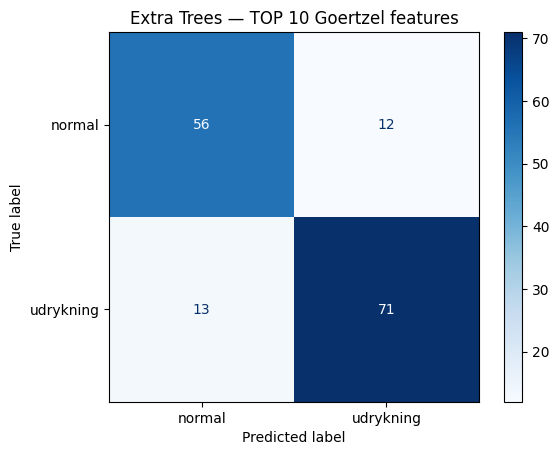

In [7]:
# ============================================================
# STEP 0 — Imports
# ============================================================

import numpy as np
import random
import matplotlib.pyplot as plt

from scipy.stats import skew, kurtosis
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay
)

np.random.seed(42)
random.seed(42)

# ============================================================
# STEP 1 — Load data
# ============================================================

X = np.load("X_windows.npy")   # (N, 200, 3)
y = np.load("y_labels.npy")

# ============================================================
# STEP 2 — Goertzel helpers
# ============================================================

def goertzel_band_energy(x, fs, f_low, f_high):
    n = len(x)
    freqs = np.arange(f_low, f_high + 1)
    energy = 0.0

    for f in freqs:
        k = int(0.5 + (n * f) / fs)
        w = 2.0 * np.pi * k / n
        cosine = np.cos(w)
        sine = np.sin(w)
        coeff = 2.0 * cosine

        q0 = q1 = q2 = 0.0
        for sample in x:
            q0 = coeff * q1 - q2 + sample
            q2 = q1
            q1 = q0

        real = q1 - q2 * cosine
        imag = q2 * sine
        energy += real*real + imag*imag

    return energy


# ============================================================
# STEP 3 — Feature extraction (GOERTZEL)
# ============================================================

def extract_stats(v):
    p10 = np.percentile(v, 10)
    return [
        np.mean(v),
        np.std(v),
        np.var(v),
        np.min(v),
        np.max(v),
        np.median(v),
        p10,
        np.sqrt(np.mean(v**2)),     # RMS
        np.sum(v**2),               # Energy
        np.max(v) - np.min(v),      # PTP
        np.mean(np.abs(v - np.mean(v))),  # MAD
        skew(v),
        kurtosis(v),
    ]


def extract_features(window, fs=100):
    x = window[:, 0]
    y_ = window[:, 1]
    z = window[:, 2]
    mag = np.sqrt(x**2 + y_**2 + z**2)

    features = []

    for v in [x, y_, z, mag]:
        features += extract_stats(v)
        features += [
            goertzel_band_energy(v, fs, 0, 5),
            goertzel_band_energy(v, fs, 5, 15),
            goertzel_band_energy(v, fs, 15, 40),
        ]

    features += [
        np.corrcoef(x, y_)[0, 1],
        np.corrcoef(x, z)[0, 1],
        np.corrcoef(y_, z)[0, 1],
    ]

    return features


print("Extracting Goertzel features...")
F = np.array([extract_features(win) for win in X])
print("Feature matrix shape:", F.shape)

# ============================================================
# STEP 4 — Feature names
# ============================================================

def get_feature_names():
    names = []
    axes = ["x", "y", "z", "mag"]
    stats = [
        "mean","std","var","min","max","median","p10",
        "rms","energy","ptp","mad","skew","kurt"
    ]
    bands = ["band0_5","band5_15","band15_40"]

    for a in axes:
        for s in stats:
            names.append(f"{a}_{s}")
        for b in bands:
            names.append(f"{a}_{b}")

    names += ["corr_xy","corr_xz","corr_yz"]
    return names

feature_names = get_feature_names()

# ============================================================
# STEP 5 — Encode labels
# ============================================================

le = LabelEncoder()
y_enc = le.fit_transform(y)

# ============================================================
# STEP 6 — Train/test split
# ============================================================

X_train, X_test, y_train, y_test = train_test_split(
    F, y_enc,
    test_size=0.2,
    random_state=42,
    stratify=y_enc
)

# ============================================================
# STEP 7 — EXTRA TREES (ALL FEATURES)
# ============================================================

print("\nTraining Extra Trees (ALL features)...")

et = ExtraTreesClassifier(
    n_estimators=400,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

et.fit(X_train, y_train)

y_pred = et.predict(X_test)

print("\nExtra Trees accuracy (ALL):", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=le.classes_,
    cmap="Blues"
)
plt.title("Extra Trees — ALL Goertzel features")
plt.show()

# ============================================================
# STEP 8 — Feature importance → TOP 10
# ============================================================

importances = et.feature_importances_
idx = np.argsort(importances)[::-1]

top10_idx = idx[:10]
top10_names = [feature_names[i] for i in top10_idx]

print("\nTOP 10 EXTRA TREES FEATURES:")
for i, name in enumerate(top10_names):
    print(f"{i+1:2d}. {name}")

F10 = F[:, top10_idx]

# ============================================================
# STEP 9 — EXTRA TREES (TOP 10 FEATURES)
# ============================================================

X_train10, X_test10, y_train10, y_test10 = train_test_split(
    F10, y_enc,
    test_size=0.2,
    random_state=42,
    stratify=y_enc
)

print("\nTraining Extra Trees (TOP 10 features)...")

et10 = ExtraTreesClassifier(
    n_estimators=400,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

et10.fit(X_train10, y_train10)

y_pred10 = et10.predict(X_test10)

print("\nExtra Trees accuracy (TOP 10):", accuracy_score(y_test10, y_pred10))
print(classification_report(y_test10, y_pred10, target_names=le.classes_))

ConfusionMatrixDisplay.from_predictions(
    y_test10, y_pred10,
    display_labels=le.classes_,
    cmap="Blues"
)
plt.title("Extra Trees — TOP 10 Goertzel features")
plt.show()
